In [1]:
import numpy as np
from python.analysis import Plots
Plots.plt.style.use("default")
Plots.plt.style.use("ggplot")

Measueing pi:

The definition for the area of a circle is

$$
A_{c} = \pi r_{c}^{2}
$$

so by measuring $r_{c}$ and $A_{c}$ you can compute $\pi$. to measure the area one would use the formula, but instead we can look at the problem in a different way. Let us compare the ratio of the square  with $r_{s}$ to a circe:

$$
R = \frac{\pi r_{c}^{2}}{r_{s}^2}
$$

and when $r_{s}$ = $r_{c}$, $R = \pi$. To indirectly measure this ratio we can do the following:
 - create a target with a circle overlapping a sqaure with $r_{s} = 2 r_{c}$.
 - throw darts randomly at the target
 - count the number of darts which are in the circle and count the number in the square, and the ratio of these numbers are directly proportional to the $R$.

Note now because $r_{s} = 2 r_{c}$ the equation is modified:

$$
R = \frac{4\pi r_{c}^{2}}{r_{s}^2}
$$


In [2]:
def count_in_circle(throws, r_c):
    r = (throws[0]**2 + throws[1]**2)**2
    return sum(r < r_c)


def count_in_square(throws, r_s):
    return sum((throws[0] < r_s) & (throws[1] < r_s))


def R(throws, r_s, r_c):
    return 4 * count_in_circle(throws, r_c)/count_in_square(throws, r_s)


def sigma_r_stat(throws, r_s, r_c):
    n_c = count_in_circle(throws, r_c)
    n_s = count_in_square(throws, r_s)
    return 4* n_c/n_s * (1/n_c + 1/n_s)**0.5

In [3]:
def throw_bias(x, y):
    return [[x], [y]]

In [4]:
r_s = 2
r_c = 1
n_throws = 1000

bx = -0.75
by = 0.75

throws = r_s * (np.random.random([2, n_throws]) - 0.5) + throw_bias(bx, by) # where did the dart land

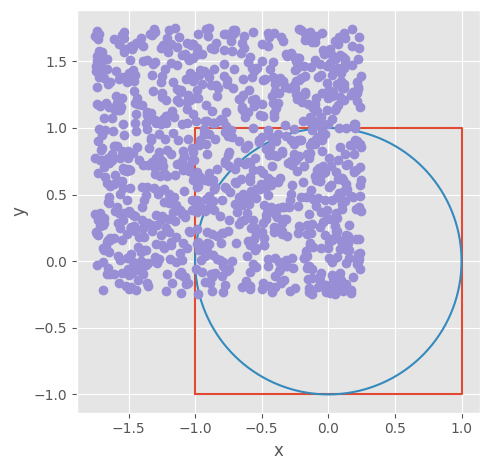

In [5]:
def visualise():
    Plots.Plot(np.array([-0.5, 0.5, 0.5, -0.5, -0.5])*r_s, np.array([-0.5, -0.5, 0.5, 0.5, -0.5])*r_s, xlabel = "x", ylabel = "y")
    theta = np.linspace(0, 2* np.pi, 1000)
    Plots.Plot(r_c * np.sin(theta), r_c * np.cos(theta), newFigure = False)
    Plots.Plot(throws[0], throws[1], marker = "o", linestyle = "", newFigure = False)
    Plots.plt.gca().set_aspect('equal')
    return

visualise()

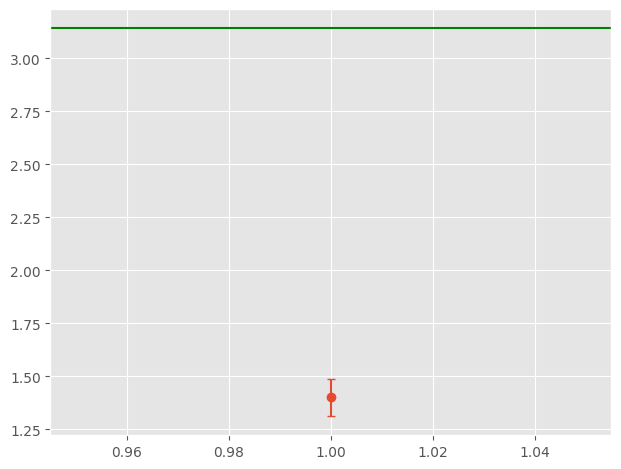

In [6]:
r = R(throws, r_s, r_c)
sigma_r = sigma_r_stat(throws, r_s, r_c)

Plots.Plot(1, r, yerr = sigma_r, marker = "o")
Plots.plt.axhline(np.pi, color = "green")

# Estimate bias in the throws

In [7]:
def estimate_bias(x):
    return np.mean(x), np.std(x)/(len(x - 1))**0.5

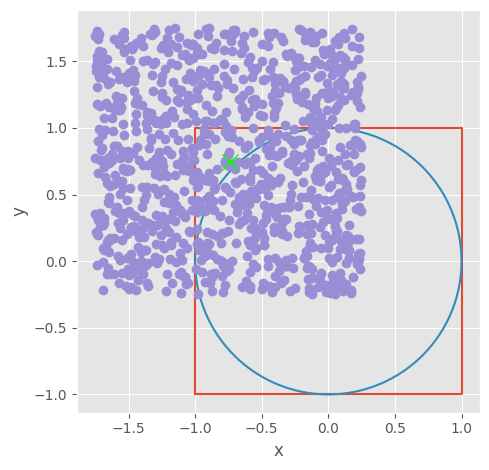

In [8]:
est_bias_x  = estimate_bias(throws[0])
est_bias_y  = estimate_bias(throws[1])
visualise()
Plots.Plot(est_bias_x[0], est_bias_y[0], xerr = est_bias_x[1], yerr = est_bias_y[1], newFigure = False, marker = "x", color = "lime", markersize = 12)

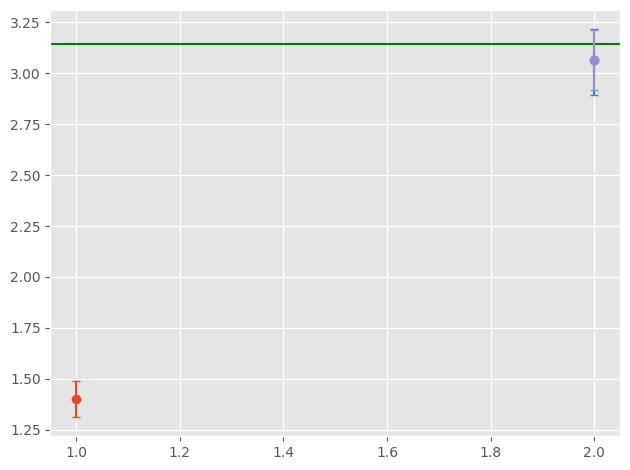

In [9]:
bias_corrected_r = R(throws - throw_bias(est_bias_x[0], est_bias_y[0]), r_s, r_c)
sigma_bias_corrected_r_stat = sigma_r_stat(throws - throw_bias(est_bias_x[0], est_bias_y[0]), r_s, r_c) # this sigma will change based on the upper and lower bounds as well...
bias_corrected_r_upper = R(throws - throw_bias(est_bias_x[0] + est_bias_x[1], est_bias_y[0] + est_bias_y[1]), r_s, r_c)
bias_corrected_r_lower = R(throws - throw_bias(est_bias_x[0] - est_bias_x[1], est_bias_y[0] - est_bias_y[1]), r_s, r_c)


Plots.Plot(1, r, yerr = sigma_r, marker = "o")
Plots.plt.axhline(np.pi, color = "green")
Plots.Plot(2, bias_corrected_r, yerr = [ [sigma_bias_corrected_r_stat + abs(bias_corrected_r - bias_corrected_r_lower)], [sigma_bias_corrected_r_stat + abs(bias_corrected_r - bias_corrected_r_upper)]], marker = "o", newFigure = False)
Plots.Plot(2, bias_corrected_r, yerr = sigma_bias_corrected_r_stat, marker = "o", newFigure = False)


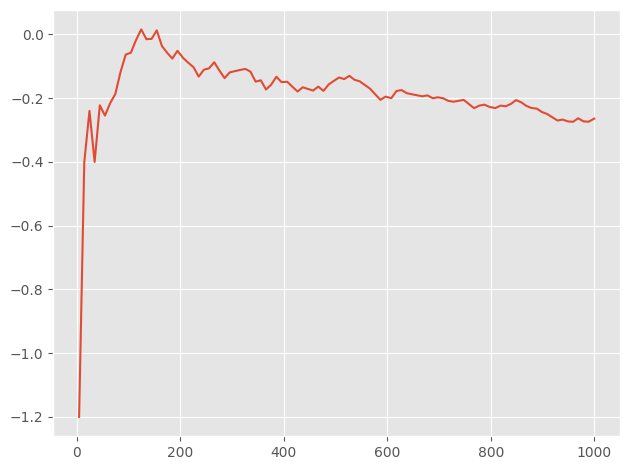

In [10]:
corrected_throws = throws - throw_bias(est_bias_x[0], est_bias_y[0])
bias_corrected_r = R(corrected_throws[:, 0:10], r_s, r_c)

n = np.linspace(5, len(corrected_throws[0]), 100, dtype = int)
out = []
for i in n:
    out.append(abs(bias_corrected_r) - R(corrected_throws[:, 0:i], r_s, r_c))

Plots.Plot(n, out)

# Fischer discriminant

In [11]:
class Fischer:
    def __init__(self, x1, x2):
        self.x1 = x1
        self.x2 = x2

    def Run(self, c1, cutsom_offset : float = 0):
        mu1 = np.array([np.mean(self.x1[c1]), np.mean(self.x2[c1])])
        mu2 = np.array([np.mean(self.x1[~c1]), np.mean(self.x2[~c1])])

        cov1 = np.cov([self.x1[c1], self.x2[c1]])
        cov2 = np.cov([self.x1[~c1], self.x2[~c1]])

        w = np.matmul(np.linalg.inv(cov1 + cov2), (mu1 - mu2))

        f = (w[0] * self.x1) + (w[1] * self.x2)
        w0 = np.median(f) + cutsom_offset
        f -= w0
        f_efficiency = sum((f > 0) == c1) / len(c1)

        print(f"{w=}")
        print(f"{w0=}")
        print(f"{f_efficiency=}")

        x = np.linspace(np.min(self.x1), np.max(self.x1), 10)
        Plots.Plot(x, 0.5 + 2 * x, color = "black", linestyle = "--", label = "exact")

        Plots.Plot(self.x1[c1], self.x2[c1], newFigure = False, marker = "o", linestyle = "", markersize = 3, xlabel = "x1", ylabel = "x2", alpha = 0.5, label = "A")
        Plots.Plot(self.x1[~c1], self.x2[~c1], newFigure = False, marker = "o", linestyle = "", markersize = 3, alpha = 0.5, label = "B")

        Plots.Plot(mu1[0], mu1[1], newFigure = False, marker = "X", linestyle = "", color = "C0", markersize = 12, label = "$\mu_{A}$")
        Plots.Plot(mu2[0], mu2[1], newFigure = False, marker = "X", linestyle = "", color = "C1", markersize = 12, label = "$\mu_{B}$")

        Plots.Plot(self.x1[c1], f[c1], marker = "o", linestyle = "", xlabel = "x1", ylabel = "F", markersize = 3)
        Plots.Plot(self.x1[~c1], f[~c1], newFigure = False, marker = "o", linestyle = "", markersize = 3)
        Plots.plt.axhline(0, label = "Fischer cut", color = "black", linestyle = "--")
        return

In [12]:
n = int(1E4)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 3, n)

w=array([ 1.25205094, -0.62119287])
w0=0.030460183391668283
f_efficiency=0.9344


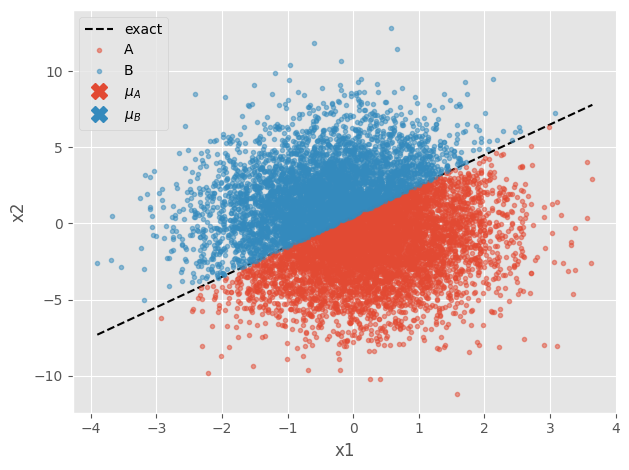

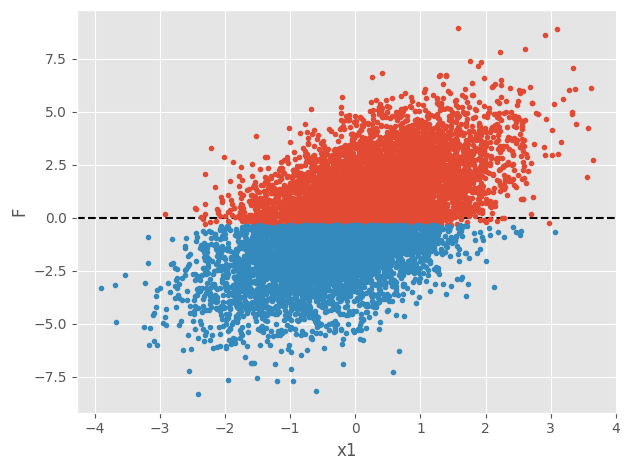

In [13]:
c1 = (-2 * x1 + x2) < 0.5 #* use fischer discriminant for this case!
fischer = Fischer(x1, x2)
fischer.Run(c1)

w=array([1.27114477, 0.33625633])
w0=-0.029149551577231814
f_efficiency=0.6293


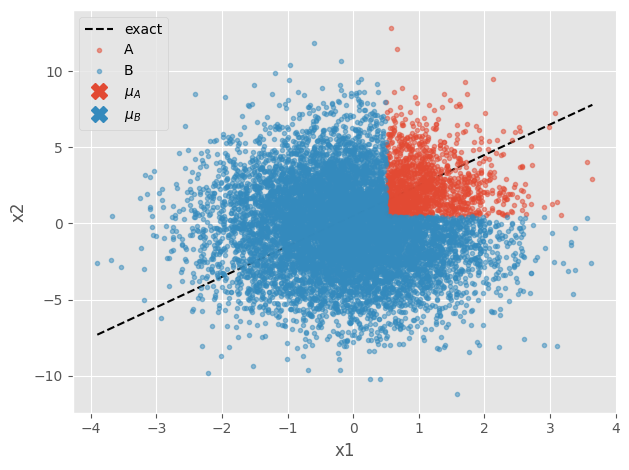

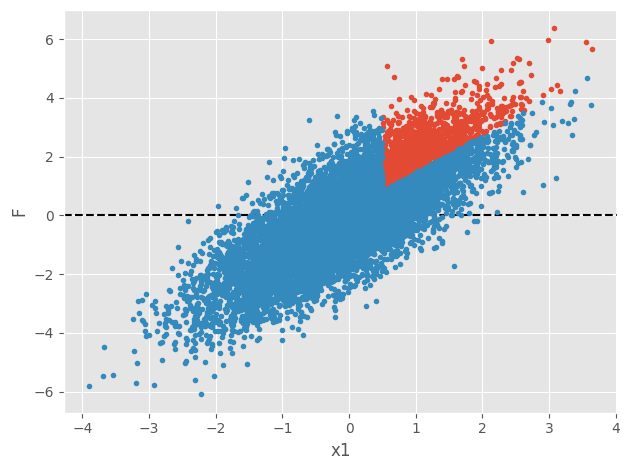

In [14]:
c1 = (x1 > 0.5) & (x2 > 0.5) #! don't use fischer discriminant for this case!
fischer = Fischer(x1, x2)
fischer.Run(c1)

# ABCD background subtraction

$$
N^{b}_{D} = N^{b}_{B}\frac{N^{b}_{C}}{N^{b}_{A}}
$$

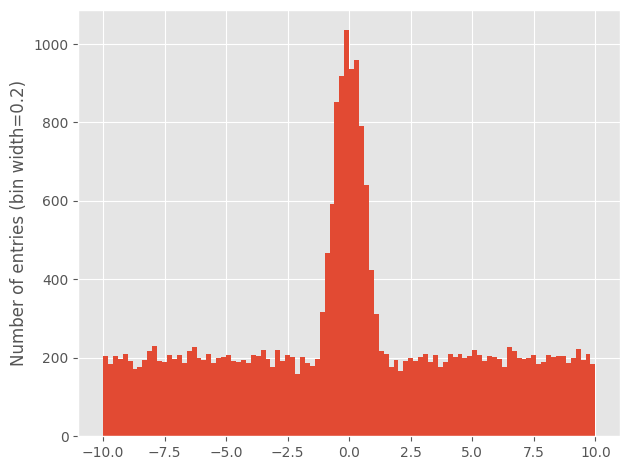

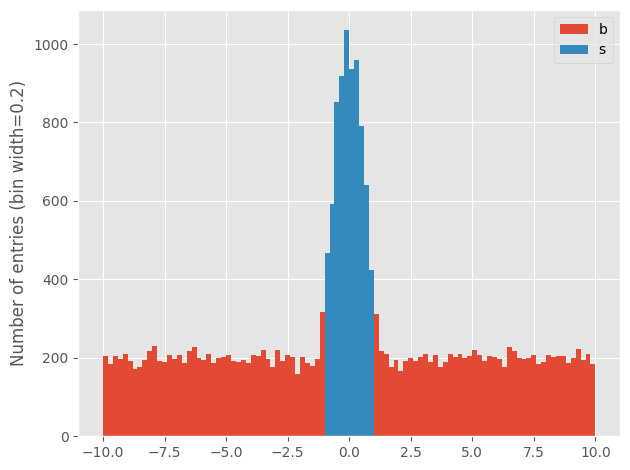

In [15]:
n = int(1E5)

def g(x):
    return np.exp(-x**2)

def u(x):
    return [0.2]*len(x)

x = np.random.uniform(-10, 10, n)
p = np.random.random(n)
a = (p < g(x)) | (p < u(x))
d = x[a]


q1, q2 = np.random.randint(0, 2, [len(d), 2], dtype = bool).T # tagging events

def regions():
    return {"A" : (q1 == 0) & (q2 == 0), "B" : (q1 == 0) & (q2 == 1), "C" : (q1 == 1) & (q2 == 0), "D" : (q1 == 1) & (q2 == 1)}


s = abs(d) < 1
Plots.PlotHist(d)
Plots.PlotHist([d[~s], d[s]], label = ["b", "s"], stacked = True)
r = regions()

0 A
[ 0.48482628  0.34446126 -0.44649947 ...  0.21619913 -0.31496064
  0.68179428]
1 B
[-0.78006616 -0.28983183  0.08616165 ...  0.39950184 -0.2928465
 -0.19843496]
2 C
[-0.85105047  0.0454066  -0.28176281 ...  0.36709506 -0.89630207
  0.92535641]
3 D
[ 0.06469046  0.35519065  0.26357262 ... -0.7385379   0.09264375
  0.73337774]


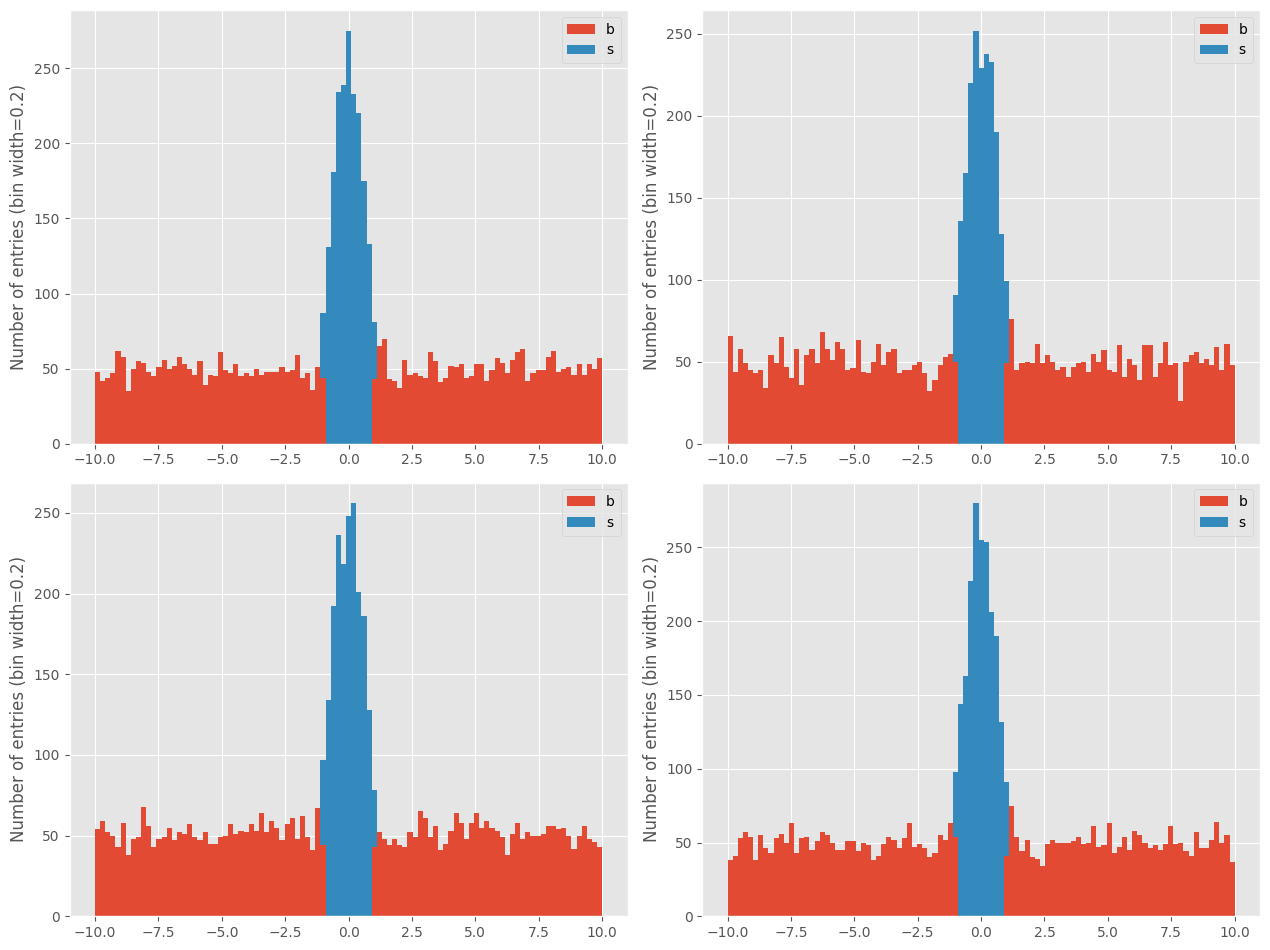

In [16]:
bins = np.linspace(-10, 10, 100) # fix the binning

for i, j in Plots.IterMultiPlot(r):
    print(i, j)
    print(d[r[j] & s])
    Plots.PlotHist([d[r[j] & ~s], d[r[j] & s]], label = ["b", "s"], bins = bins, stacked = True, newFigure = False)


# estimate backgrounds

{'A': (48.96052631578947, 1.0162609123254671), 'B': (49.0921052631579, 1.2247703159653265), 'C': (50.81578947368421, 1.0963592903077606), 'D': (50.952354347303356, 1.9856739290522063)}


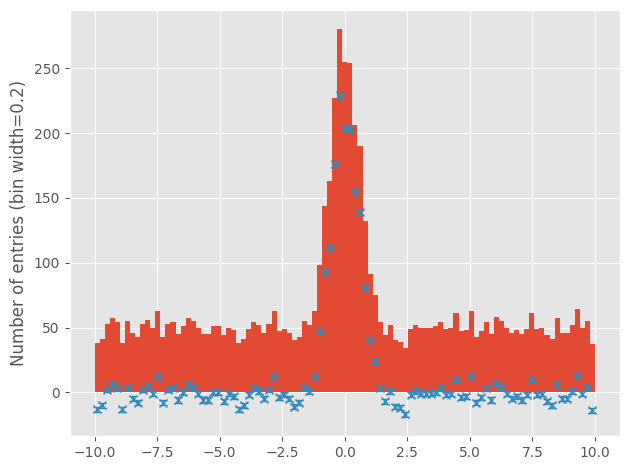

In [18]:
def estimate_background(data):
    background = abs(data) > 2.5
    counts = np.histogram(data[background], bins)[0]
    counts = counts[counts != 0]
    return np.mean(counts), np.std(counts) / np.sqrt(len(counts)-1) 


def ABCD_method(data, reg):
    n_b = {i : estimate_background(data[reg[i]]) for i in ["A", "B", "C"]}

    n_D = (n_b["C"][0]/n_b["A"][0]) * n_b["B"][0] # ABCD subtraction

    n_D_e = n_D * sum([(n_b[i][1]/n_b[i][0])**2 for i in ["A", "B", "C"]])**0.5
    n_b["D"] = (n_D, n_D_e)
    print(n_b)
    return n_b["D"]

n_background = ABCD_method(d, r)
signal_data_hist = np.histogram(d[r["D"]], bins = bins)

centers = (signal_data_hist[1][1:] + signal_data_hist[1][:-1]) / 2

Plots.PlotHist(d[r["D"]], bins = bins)
Plots.Plot(centers, signal_data_hist[0] - n_background[0], yerr = n_background[1], newFigure = False, marker = "x", linestyle = "")

# Plots.plt.hist(signal_data_hist[1][:-1], bins = signal_data_hist[1], weights = signal_data_hist[0] - n_background[0])


# Custom

In [353]:
import numpy as np
from scipy.optimize import minimize
import scipy.stats as stats
from python.analysis import Plots
from python.analysis.cross_section import SetPlotStyle, Toy
SetPlotStyle(dpi = 100)

def f(mus : np.array, observed, lambdas : np.array):
    # expected = np.sum(mus * lambdas.T, 1)

    expected = mus[0] * lambdas[0] + mus[1] * lambdas[1] + mus[2] * lambdas[2] + (4 - mus[2] - mus[1] - mus[0]) * lambdas[3]

    return stats.poisson.logpmf(observed, expected)
    # t = ((observed / sum(mus)) - expected) / np.sqrt(expected)
    # return np.log(stats.norm.pdf(t, loc = 0, scale = 1))

def nll(mus : np.array, vars : list[np.array, np.array]):
    l = 1
    n = vars[0]
    lambdas = vars[1]
    for c in range(len(n)):
        l += np.sum(f(mus, n[c], lambdas[c]))

    return -2 * l

mus = np.array([1, 1, 1]) # fit parameters (1 per sample)
n = np.array([[10, 3], [5, 6], [6, 9], [8, 7]]) # obsevations (1 per channel)
lambdas = [np.array([[3, 1], [0, 2], [14, 3], [3, 4]]), np.array([[3, 1], [0, 2], [14, 3], [3, 4]]), np.array([[3, 1], [0, 2], [14, 3], [3, 4]]), np.array([[3, 1], [0, 2], [14, 3], [3, 4]])] # first index is channel, second is samples

nll(mus, [n, lambdas])

82.66578939016215

In [343]:
toy = Toy("work/2023/toys/xs_toy_1GeV_gaussian_60MeV_fit_input.hdf5", smearing = True)
bins = np.linspace(0, 1050, 21)

observations = []
for r in toy.reco_regions:
    observations.append(np.histogram(toy.df.KE_int_smeared[toy.reco_regions[r]].values, bins)[0])
observations = np.array(observations)

expecteds = []
for r in toy.reco_regions:
    channel = []
    for t in toy.truth_regions:
        channel.append(np.histogram(toy.df.KE_int_smeared[toy.reco_regions[r].values & toy.truth_regions[t].values].values, bins)[0])
    expecteds.append(channel)
expecteds = np.array(expecteds)

nll(mus, [observations, expecteds])

minimize(nll, mus, [observations, expecteds], method = "Nelder-Mead", options = {"maxfev" : 10000}, bounds = [(0, None), (0, None), (0, None), (0, None)])

 final_simplex: (array([[0.98085503, 1.00020088, 1.12292235, 1.08312663],
       [0.98084626, 1.00022376, 1.1229385 , 1.08308612],
       [0.98084524, 1.00020773, 1.12294309, 1.08308529],
       [0.98087163, 1.00018018, 1.12291227, 1.08314401],
       [0.98085086, 1.0001964 , 1.12293612, 1.08311306]]), array([1573.89859956, 1573.89861486, 1573.89862608, 1573.89865063,
       1573.89865849]))
           fun: 1573.8985995559005
       message: 'Optimization terminated successfully.'
          nfev: 156
           nit: 90
        status: 0
       success: True
             x: array([0.98085503, 1.00020088, 1.12292235, 1.08312663])

In [355]:
import iminuit
# nll(mus, [observations, expecteds])
result = iminuit.minimize(nll, x0 = mus, args = [[observations, expecteds]], bounds = [(0.0, None), (0.0, None), (0.0, None)])

In [356]:
print(np.array(result["minuit"]))

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6345                       │              Nfcn = 67               │
│ EDM = 2.63e-07 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────